In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Loading helper functions

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
from PIL import Image
from tqdm.auto import tqdm

# Suppress tqdm bars
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

# Must run everything in 64 bit for numerical robustness
from jax import config
config.update("jax_enable_x64", True)

from pathlib import Path

import automembrane.plot_helper as ph
from automembrane.geometry import ClosedPlaneCurveGeometry

# Force analysis of ActuAtor

**Eleanor Jung, Cuncheng Zhu, Christopher T. Lee, Padmini Rangamani**

**University of California San Diego**

Summary of protocol for estimating forces on the membrane. Nuclei were traced from the EM images manually using Fiji. Assuming the Helfrich-Canham-Evans and surface energy of the membrane,

$$E =  \underbrace{\int_\Omega \kappa_b H^2 dA}_{E_b} + \underbrace{\int_\Omega \sigma dA}_{E_\sigma},$$

where $\kappa_b$ is the bending modulus, $H$ is the mean curvature given by the two principal curvatures, $(k_1 + k_2)/2$,  $\sigma$ is the prescribed constant surface tension, and $dA$ the area element. Given that the segmented EM images are plane curves, we assume naively that the out of plane principal curvature is naught ($k_2 = 0$). Rewriting as an energy density (per length) and simplifying,

$$\frac{E_b}{l} =\frac{\kappa_b}{4} \int_C k_1^2 ds,$$

and 

$$\frac{E_\sigma}{l} =  \sigma \int_C ds,$$ 


where $l$ is the depth relating the integrals over area, $\Omega$, and the plane curve, $C$; $ds$ is the arc-length element. To obtain the areal force density $f$ such that $f ds = -\nabla (E/l)$, we use automatic differentiation using [`jax`](https://jax.readthedocs.io). Note that $f$ is independent of the length scale $l$. We choose the sum of half the length of each incident edge to be the dual length, $ds_i$, of the $i^{\text{th}}$ vertex, $v_i$.

## Test Case: Straight Line Object

When the membrane is a completely straight line, such that its coordinates are given by $(x_i, 0)$ for $i = 1, \ldots, N$, the curvature is zero everywhere ($k_i = 0$), and consequently, the bending energy is zero ($E_b = 0$). The tension energy is:

$$
E_\sigma = \sigma \sum_{i=1}^{N-1} (x_{i+1} - x_i).
$$

The force, given by $f_i = -\frac{\partial E_\sigma}{\partial x_i}$, is:

$$
f_1 = \sigma
$$
$$
f_i = 0 \quad (i = 2, \ldots, N-1)
$$
$$
f_N = -\sigma.
$$


The simulation result below appears to match the theoretical prediction.

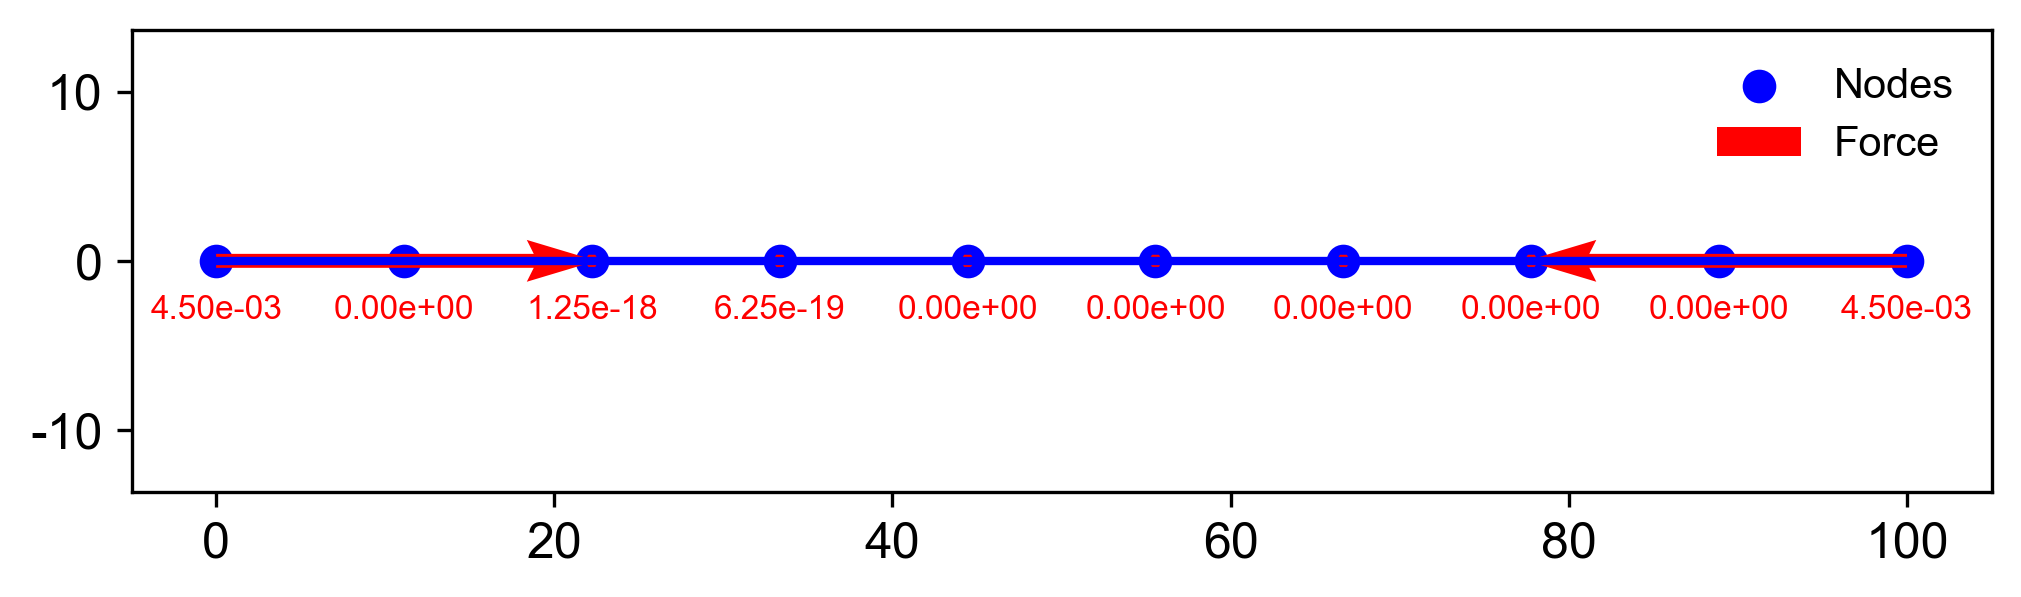

force =  0.05 pN nm


In [17]:
from sample import make_straight_line, plot_system
from variation_run import get_force_density

L_etoe = 100
N_node = 10
coords = make_straight_line(N_node = N_node, L_etoe = L_etoe, point_dist = "unif")

parameters = {
    "Kb":  0 / 4,   # Bending modulus (pN nm)
    "Ksg": 0.05,    # Global stretching modulus (pN nm)
    "Ksl": 0,
    "boundary": "open"
}

force = get_force_density(parameters, coords)
plot_system(coords, force)

print("force = ", round(force[1,0,0] *(L_etoe/(N_node-1)), 2), "pN nm")


## Test Case: Parabora

Intuitively, nodes with higher curvature yield higher force

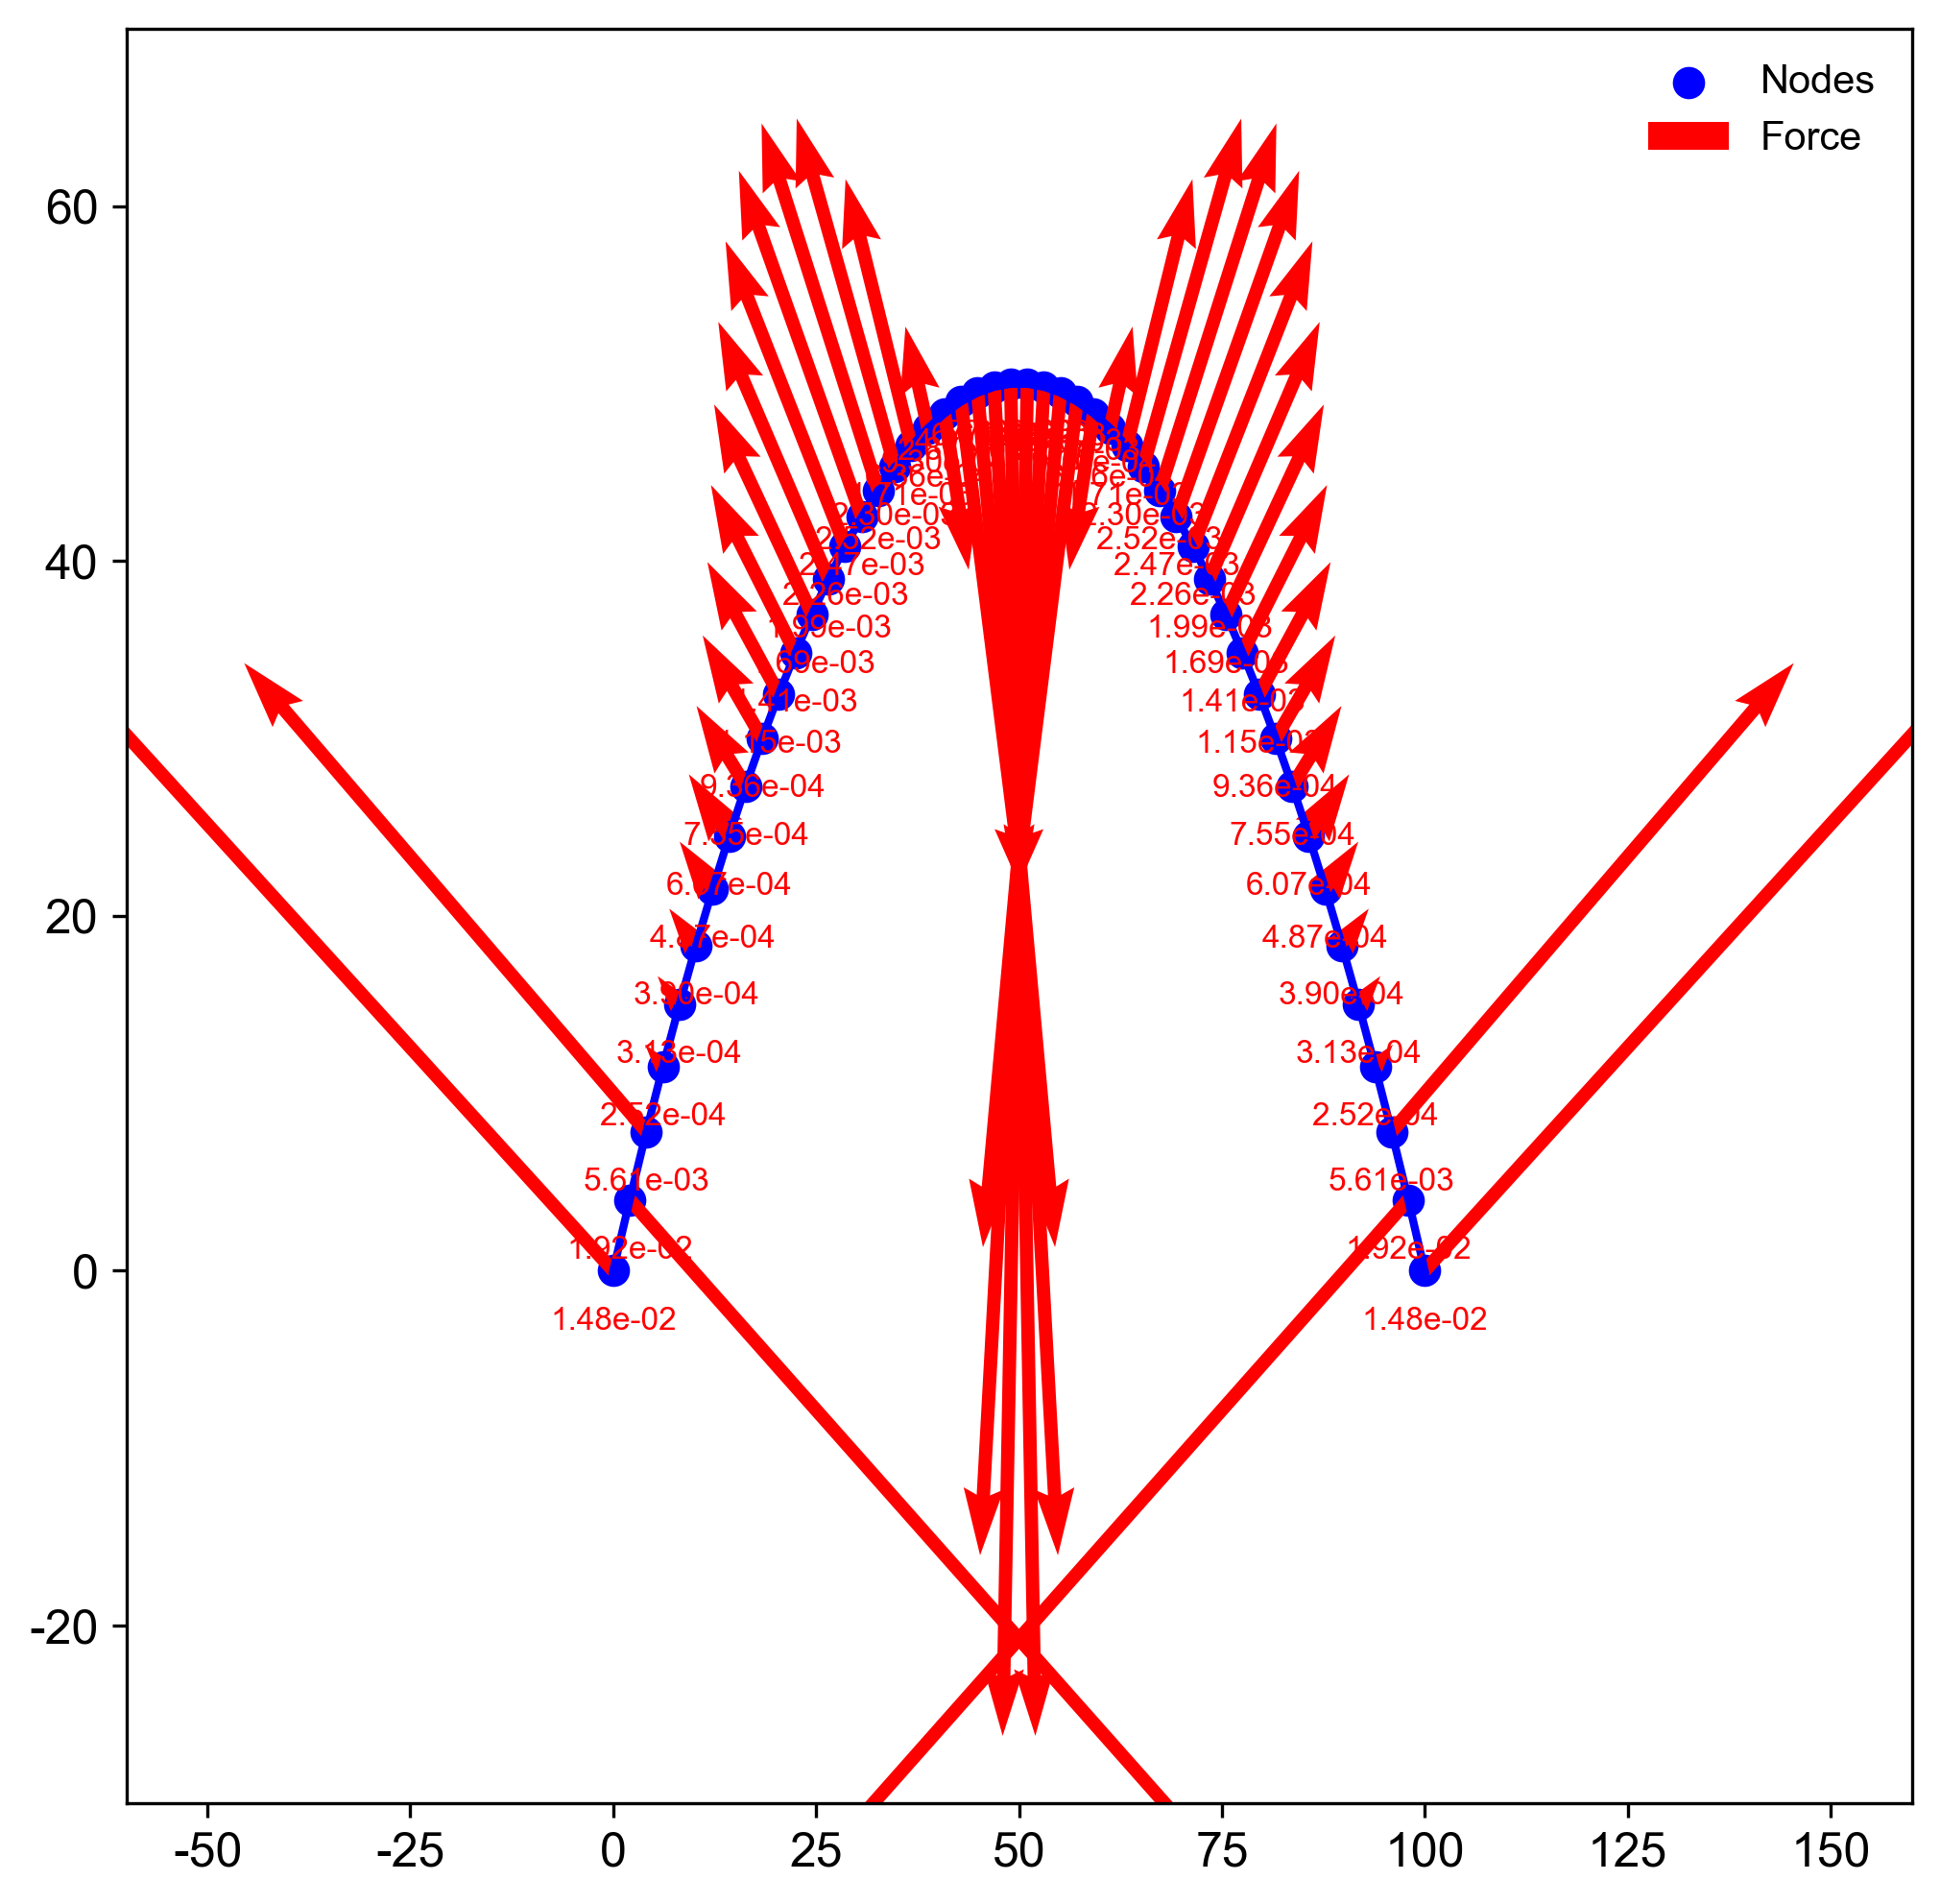

In [2]:
from sample import make_parabola, plot_parabola
from variation_run import get_force_density

N_node = 50
L_etoe = 100
height = 50
coords = make_parabola(N_node = N_node, L_etoe = L_etoe, height = height, point_dist = "unif")

parameters = {
    "Kb":  100 / 4,   # Bending modulus (pN nm)
    "Ksg": 0,    # Global stretching modulus (pN nm)
    # "Ksg": 0.05,    # Global stretching modulus (pN nm)
    "Ksl": 0,
    "boundary": "open"
}

force = get_force_density(parameters, coords)
plot_parabola(coords, force)

# print("force = ", round(force[1,0,0] *(L_etoe/(N_node-1)), 2), "pN nm")

### Force analysis on the bud

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
file = Path('coordinates/Membrane_2018June_Tomo26_CME_Invagination.txt')

Energy relaxation:   0%|          | 0/80000 [00:00<?, ?it/s]

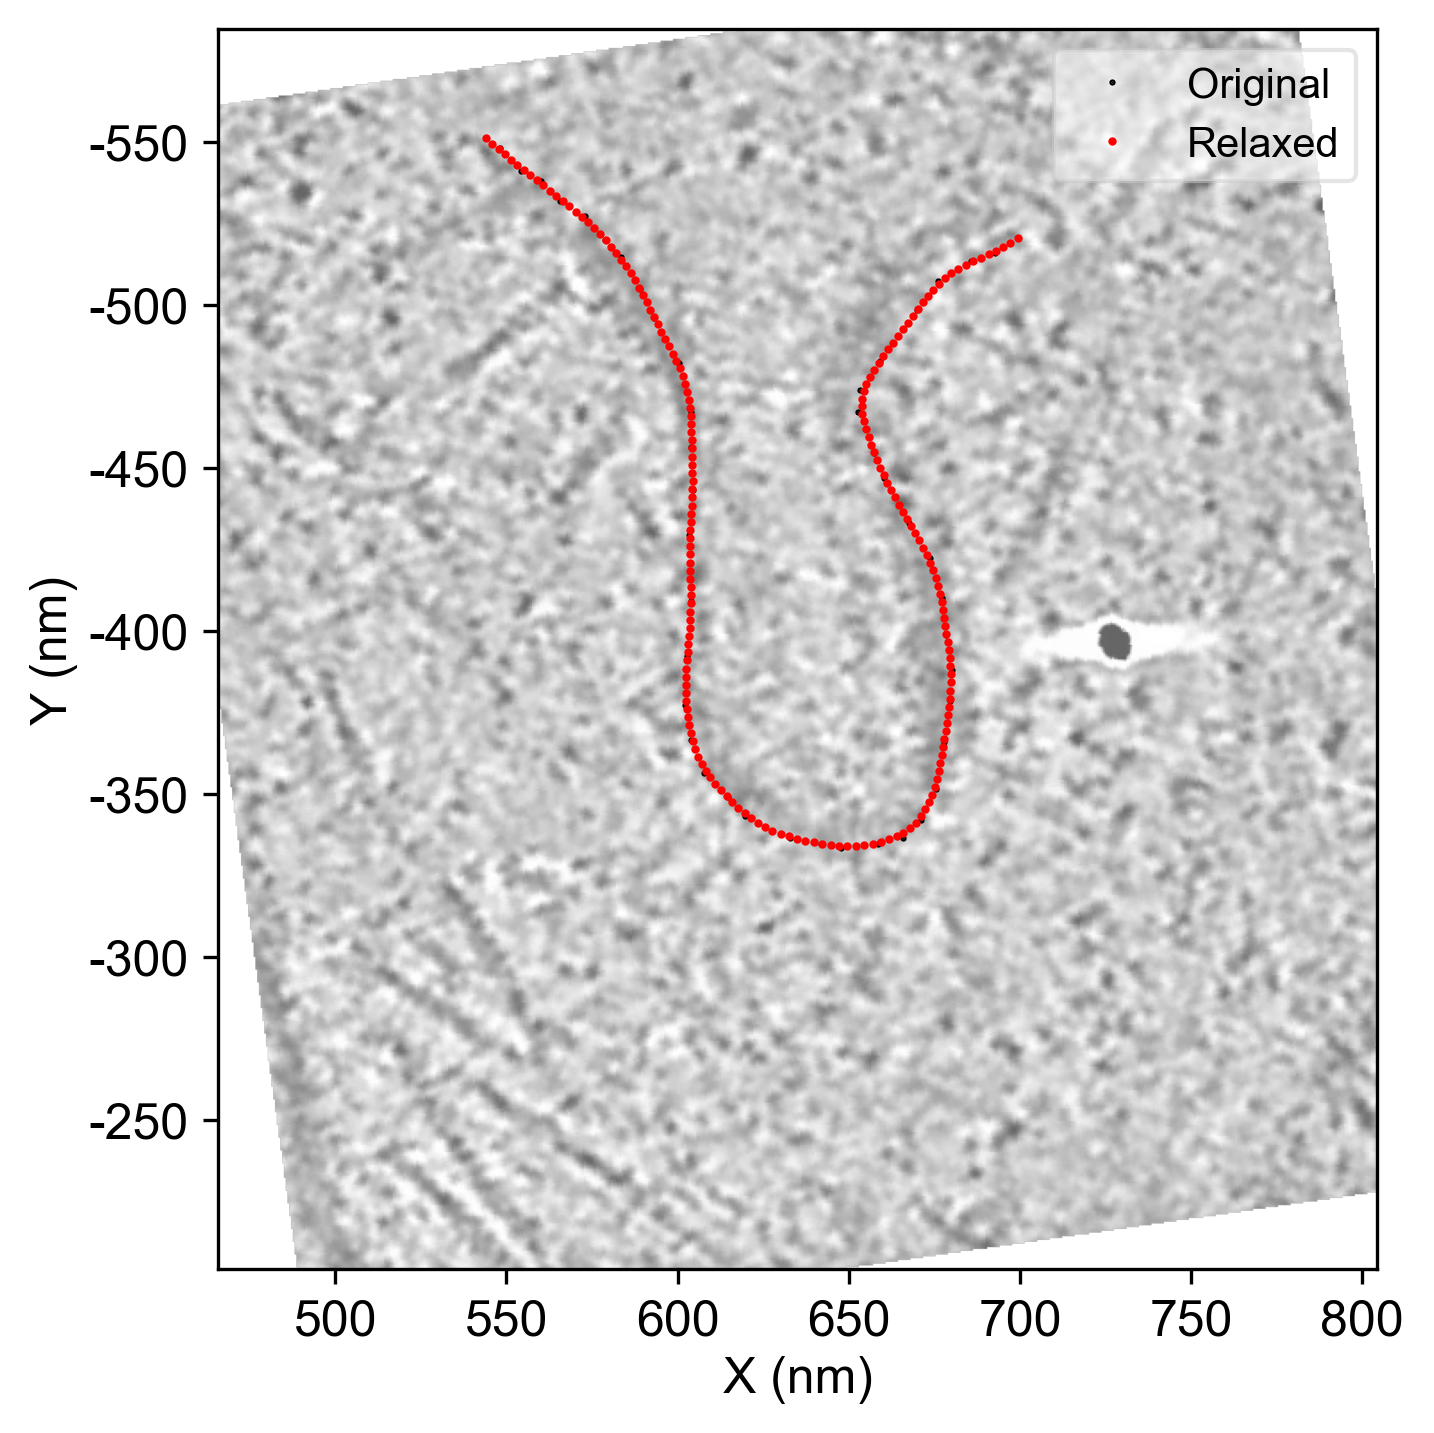

In [9]:
from variation_relax import preprocess_mesh, relax_bending, plot_contour

## relaxation step ##
coords, original_coords = preprocess_mesh(file, resample_geometry=True, n_vertices=200)
params = {
    "Kb": 10,
    "Ksg": 10,
    "Ksl": 1.0,
    "dt": 1e-5,
    # "n_iter": int(8e2),
    "n_iter": int(8e4),
    # "boundary": "open",
    "boundary": "pinned",
}
relaxed_coords = relax_bending(coords, **params)

np.savez(
    f"relaxed_coords/{file.stem}",
    relaxed_coords=relaxed_coords,
    original_coords=original_coords,
)

fig = plt.figure(figsize=(5, 5))
plot_contour(
    fig,
    file.stem,
    original_coords,
    relaxed_coords,
)
fig.set_tight_layout(True)
plt.savefig("relaxed_coords/" + file.stem + ".png")
plt.show()
fig.clear()
plt.close(fig)


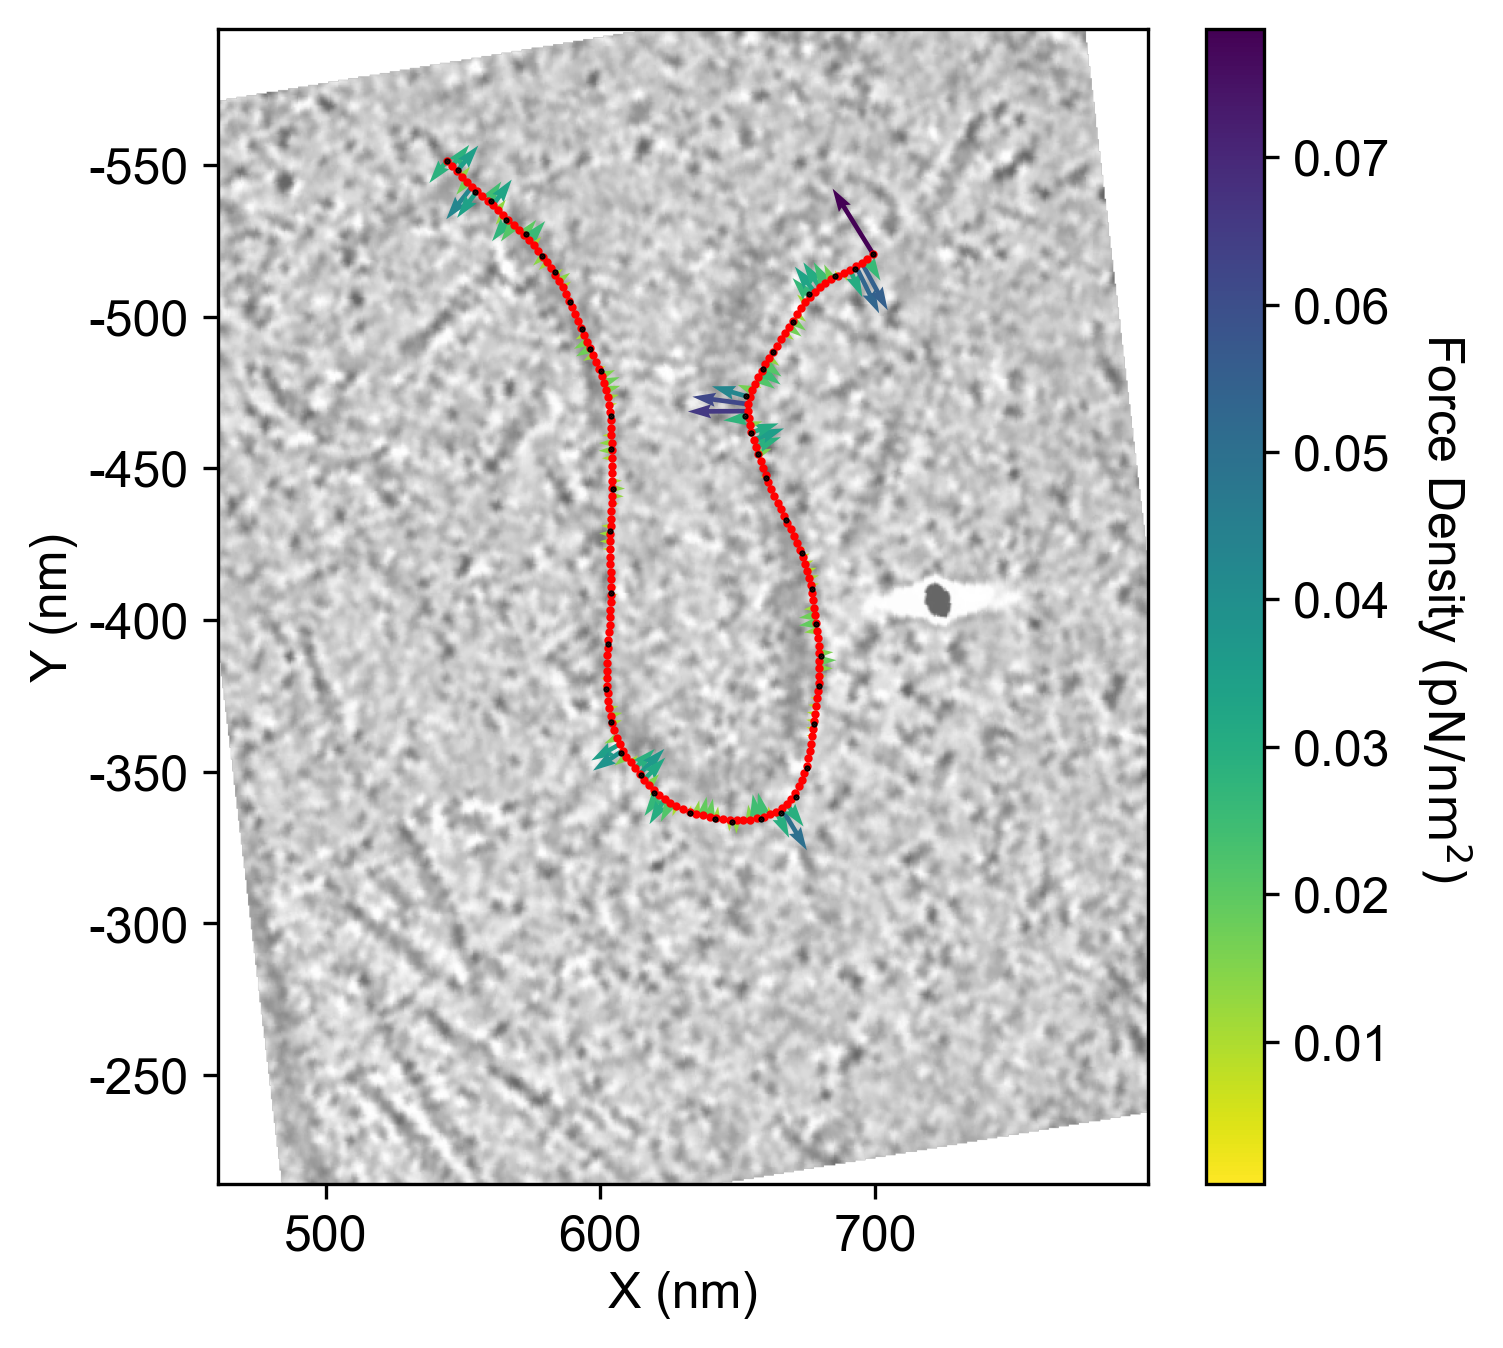

In [7]:
import numpy as np
from variation_run import get_force_density
from make_movie import plot_dimensional


## Force calculation step ##

data = np.load(f"relaxed_coords/{file.stem}.npz")
relaxed_coords = data["relaxed_coords"]
original_coords = data["original_coords"]

parameters = {
    "Kb": 100 / 4,  # Bending modulus (pN um; original 1e-19 J)
    # "Kb": 0,  # Bending modulus (pN um; original 1e-19 J)
    # "Ksg": 0.05,  # Global stretching modulus (pN um/um^2; original 0.05 mN/m)
    "Ksg": 0,  # Global stretching modulus (pN um/um^2; original 0.05 mN/m)
    "Ksl": 0,   # Regularization modulus (pN um; 0), 
    # "boundary": "pinned",
    # "boundary": "fixed"
    "boundary" : "open"
}

forces = get_force_density(parameters, relaxed_coords)
total_force = np.sum(forces, axis=0)
fig = plot_dimensional(
    file.stem,
    original_coords,
    relaxed_coords,
    total_force
)

plt.savefig("figures/" + file.stem + "_zoom_forces.png")
plt.show()
fig.clear()
plt.close(fig)


### Non-dimensionalization
Because the exact material properties of the nuclear membrane are unknown, non-dimensional parameter variation enables efficient exploration across physical regimes.
We need to choose a length scale to compare the magnitude of material properties, namely the surface tension and bending rigidity. To reflect the competition between surface tension and bending rigidity at highly stressed region, we choose the curvature scale $C_0$ to be the maximum absolute curvature of the geometry, which varies for each image. Then we can define a dimensionless surface tension $\bar{\sigma} = \frac{\sigma}{\kappa_b C_0^2}$, and sweep from 0 to $\bar{\sigma}_{\text{max}}$. We obtain the transition of membrane from bending dominated to tension dominate regimes.
<!-- We first choose two scaling parameters bending rigidity $\kappa_b$ and curvature $C_0$. First, we scale the coordinates of trace by $C_0$ before importing it into the energy evaluation. By fixing the dimensionless bending rigidity $\bar{\kappa_b} = 1$, we conduct parameter sweep on the nondimensional surface tension $\bar{\sigma} (= \frac{\sigma}{\kappa_b C_0^2} )$. The resultant force computed $\bar{f} = \frac{\bar{\nabla} \overline{(E/l)}}{d\bar{s}} $ is therefore also dimensionless. If needed, we can recover the force with unit by scaling it using the relationship $f = \kappa_b C_0^3 \bar{f} $.  -->
<!-- We obtain the value for ${\kappa_b}$ from Lipowsky et al., 1991 and the range for ${\sigma}$ from Gautheir et al., 2012, while the length scale is approximately the radius of our cells.
Bending rigidity (${\kappa_b}$): $10^{-19} J$ or ${10^{-7}}$ $\mathrm{\frac{kg~{\mu m^2}}{s^2}}$
Surface tension (${\sigma}$): $0.01$ to $0.04$ $\mathrm{\frac{mN}{m}}$ or ${10^{-5}}$ to ${4~*~10^{-5}}$ $\mathrm{\frac{kg}{s^2}}$
To non-dimensionalize the relationship between the bending rigidity, ${\kappa_b}$, and the surface tension, ${\sigma}$, we calculate the range of values for:
$$\mathrm{({\sigma}~*~{\frac{1}{\kappa_b}})~*~(length~scale){^2}}$$
Minimum:
$$\mathrm{{\frac{10^{-5}~kg}{1~{s^2}}}~*~{\frac{1~{s^2}}{10^{-7}~kg~\mu {m^2}}}~*~(5~\mu m){^2}~=~2500}$$
Maximum:
$$\mathrm{{\frac{4~*~10^{-5}~kg}{1~{s^2}}}~*~{\frac{1~{s^2}}{10^{-7}~kg~\mu {m^2}}}~*~(5~\mu m){^2}~=~10000}$$ -->

In [24]:
from variation_run import get_dimensional_tension, get_force_density

Ksg_range = np.linspace(0, 0.3, 1 + 2**6)

Ksg_force = {}
data = np.load(f"relaxed_coords/{file.stem}.npz")
relaxed_coords = data["relaxed_coords"]
for Ksg_ in tqdm(Ksg_range, desc="Parameter variation"):
    # Instantiate material properties
    Kb = 0.1
    Ksg = get_dimensional_tension(Ksg_, Kb, relaxed_coords)
    parameters = {
        "Kb": Kb / 4,  # Bending modulus (pN um; original 1e-19 J)
        "Ksg": Ksg,  # Global stretching modulus (pN um/um^2; original 0.05 mN/m)
        "Ksl": 0,
    }
    Ksg_force[Ksg_] = get_force_density(parameters, relaxed_coords)

Ksg_force = np.array([Ksg_force])
np.savez(f"forces/{file.stem}", Ksg_range=Ksg_range, Ksg_force=Ksg_force)


### Identify the plausible physical regime
We predict that actin needs to pull in bending dominated and push in tension dominated regimes. 

In [27]:
from make_movie import make_nondimensional_movie

data = np.load(f"forces/{file.stem}.npz", allow_pickle=True)
Ksg_range = data["Ksg_range"]
Ksg_force = data["Ksg_force"][0]
print(type(data["Ksg_force"]))
print(type(data["Ksg_force"][0]))
print(Ksg_force)

# data = np.load(f"relaxed_coords/{file.stem}.npz")
# relaxed_coords = data["relaxed_coords"]
# original_coords = data["original_coords"]

# make_nondimensional_movie(
#     file.stem,
#     original_coords,
#     relaxed_coords,
#     Ksg_force,
#     Ksg_range,
#     x_lim=np.array([18, 21]),
#     y_lim=np.array([12, 16]),
#     style = "quiver"
# )


<class 'numpy.ndarray'>
<class 'dict'>
{np.float64(0.0): array([[[ 0.05427149,  0.56563593],
        [ 0.00619658, -0.21293579],
        [-0.03036047,  0.07159042],
        ...,
        [ 0.07932118,  0.61263752],
        [ 0.09190004,  0.26511547],
        [-0.        , -0.        ]],

       [[-0.        , -0.        ],
        [-0.        , -0.        ],
        [-0.        , -0.        ],
        ...,
        [-0.        , -0.        ],
        [-0.        , -0.        ],
        [-0.        , -0.        ]],

       [[-0.        , -0.        ],
        [-0.        , -0.        ],
        [-0.        , -0.        ],
        ...,
        [-0.        , -0.        ],
        [-0.        , -0.        ],
        [-0.        , -0.        ]]]), np.float64(0.0046875): array([[[ 0.05427149,  0.56563593],
        [ 0.00619658, -0.21293579],
        [-0.03036047,  0.07159042],
        ...,
        [ 0.07932118,  0.61263752],
        [ 0.09190004,  0.26511547],
        [-0.        , -0.        

In [17]:
# Show video in notebook
# Video(f"movies/{file.stem}_nondim_variation.mp4", width=600, html_attributes="controls loop")
from IPython.display import display
display(Image.open("figures/34D-grid2-s3-acta1_001_16_Ksg0.0.png"))
display(Image.open("figures/34D-grid2-s3-acta1_001_16_Ksg150.0.png"))
display(Image.open("figures/34D-grid2-s3-acta1_001_16_Ksg300.0.png"))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/atsushi/Library/Mobile Documents/com~apple~CloudDocs/simulation/akamatsu/actuator_ori/actuator_example/figures/34D-grid2-s3-acta1_001_16_Ksg0.0.png'

### Example dimensional model in tension dominated regime
If we assume the parameters $\kappa_b= 0.1~\mathrm{ pN \cdot μm} \approx 24~\mathrm{k_B T}$ and $\sigma = 50~\mathrm{pN/μm}$. The membrane force density of *34D-grid2-s3-acta1_001_16* can be estimated.

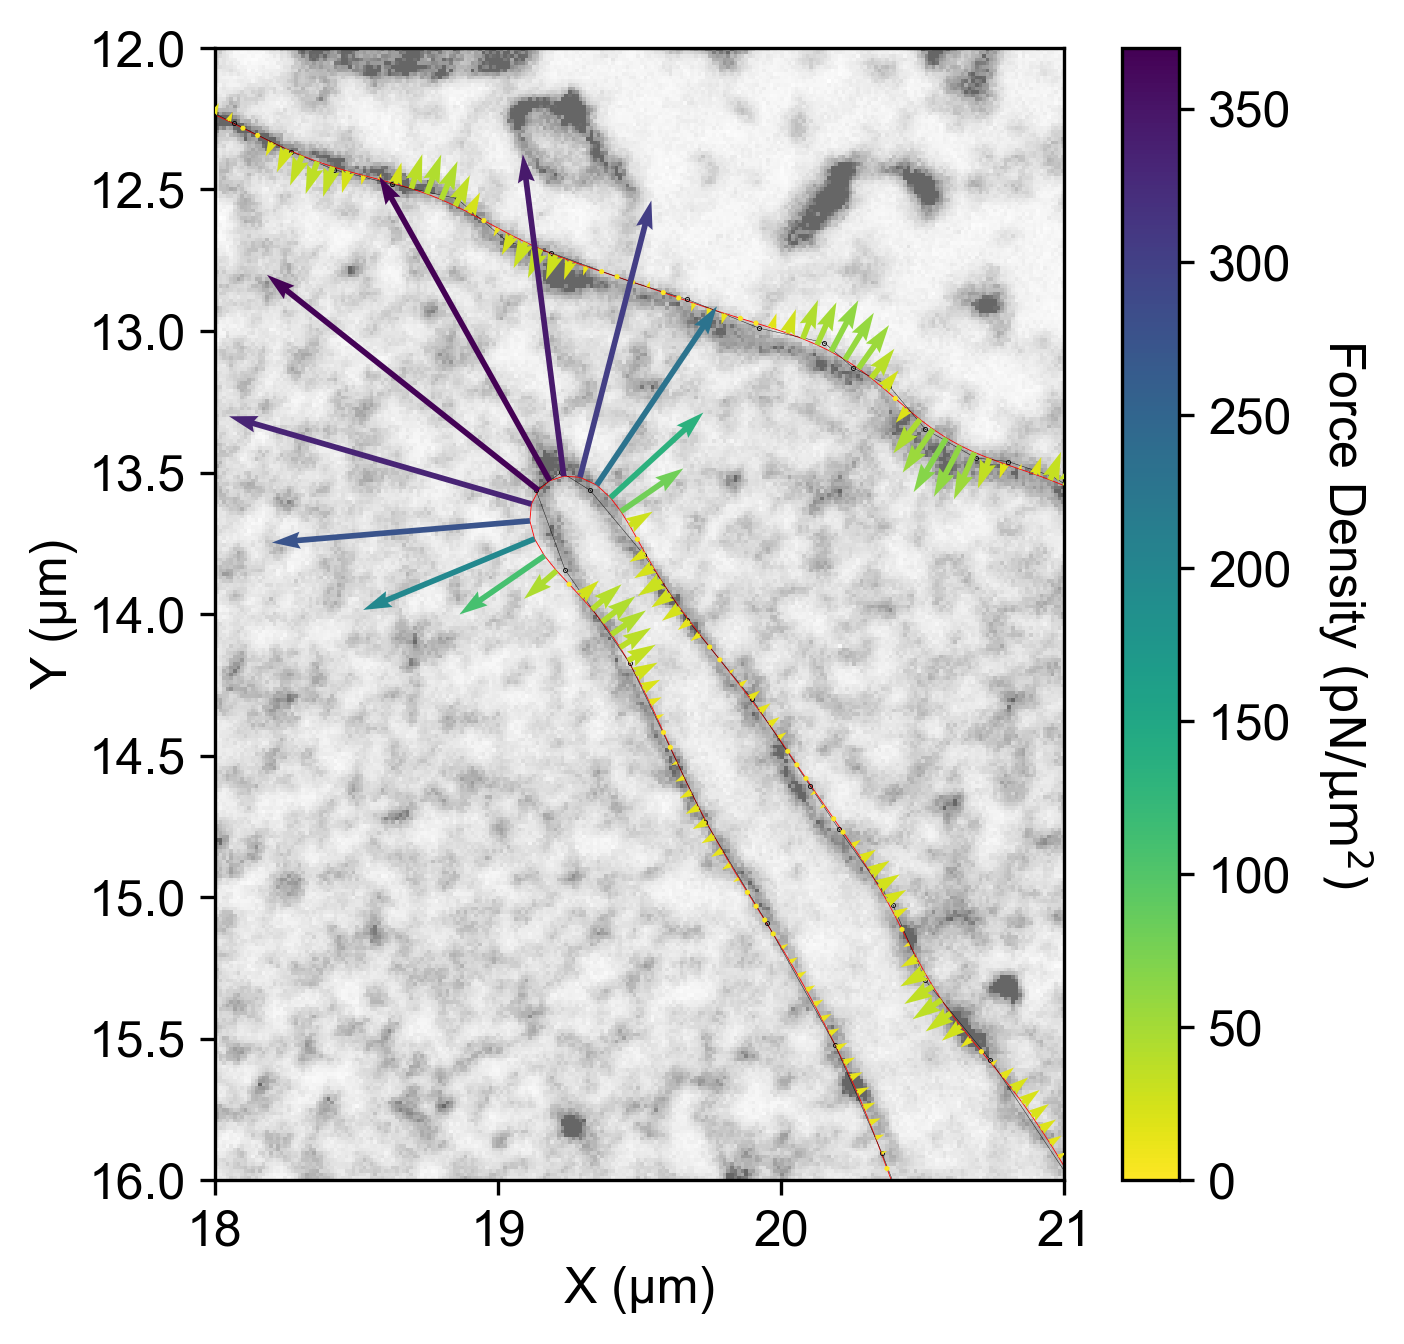

In [8]:
import numpy as np
from actuator_constants import image_microns_per_pixel

def plot_dimensional(total_force): 
    fig = plt.figure(figsize=(5, 5))

    x_lim = np.array([18, 21])
    y_lim = np.array([12, 16])
        
    ax = fig.add_subplot(autoscale_on=False, xlim=x_lim, ylim=y_lim)
    # flip y-axis
    ax.set_ylim(ax.get_ylim()[::-1])
    with Image.open(f"raw_images/{file.stem}.TIF") as im:
        pixel_scale = image_microns_per_pixel[file.stem]
        x_lim_pix = (x_lim / pixel_scale).round()
        y_lim_pix = (y_lim / pixel_scale).round()

        im = im.crop((x_lim_pix[0], y_lim_pix[0], x_lim_pix[1], y_lim_pix[1]))

        plt.imshow(
            im,
            alpha=0.6,
            extent=(x_lim[0], x_lim[1], y_lim[1], y_lim[0]),
            zorder=0,
            cmap=plt.cm.Greys_r,
        )

    ax.set_ylabel(r"Y (μm)")
    ax.set_xlabel(r"X (μm)")

    # Shrink current axis
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    f_mag = np.linalg.norm(total_force, axis=1)
    q = ax.quiver(
        relaxed_coords[:, 0],
        relaxed_coords[:, 1],
        -total_force[:, 0],
        -total_force[:, 1],
        f_mag,
        cmap=mpl.cm.viridis_r,
        angles="xy",
        units="xy",
        label="force",
        scale=300,
        scale_units="xy",
        width=0.02,
        zorder=10,
    )
    cbar = fig.colorbar(
        q,
        ax=ax,
    )
    cbar.ax.get_yaxis().labelpad = 20
    cbar.ax.set_ylabel("Force Density $\mathrm{(pN/\mu m^2)}$", rotation=270)
    # ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    # cbar.ax.set_ylabel("Force Density ($\mathregular{pN/\mu m^2}$)", rotation=270)
    (line,) = ax.plot(
        relaxed_coords[:, 0], relaxed_coords[:, 1], linewidth=0.2, color="r"
    )

    # outline plots
    (original_line,) = ax.plot(
        original_coords[:, 0],
        original_coords[:, 1],
        "-o",
        markersize=0.2,
        linewidth=0.1,
        color="k",
    )
    return fig
    

parameters = {
    "Kb": 0.1 / 4,  # Bending modulus (pN um; original 1e-19 J)
    "Ksg": 50,  # Global stretching modulus (pN um/um^2; original 0.05 mN/m)
    "Ksl": 0,   # Regularization modulus (pN um; 0)
}

forces = get_force_density(parameters, relaxed_coords)
total_force = np.sum(forces, axis=0)
fig = plot_dimensional(total_force)

plt.savefig("figures/" + file.stem + "_zoom_forces.png")
plt.show()
fig.clear()
plt.close(fig)


#### Napkin math estimating actin coverage 

Assuming an actin filament is ~7 $\mathrm{nm}$ in diameter a conservative surface area occupancy is 4.9e-5 $\mathrm{μ m^2}$. Depending on cell conditions a single actin filament can produce ~1 $\mathrm{pN}$ of force. Then we can compute the maximum force density assuming full coverage. Naively assuming that force from actin linearly scale with its occupancy, and there is no branching and additional magnification mechanism, the area coverage can be estimated.

In [9]:
actin_force_density = 1.0 / 4.9e-5  # pN/um^2
print("Actin force density:", actin_force_density, "pN/um^2")
f_mag = np.linalg.norm(total_force, axis=1)
print(
    "Max force density of membrane:",
    np.max(f_mag),
    "pN/um^2;",
)
print("Coverage:", np.max(f_mag) / actin_force_density * 100, "%")
dualLengths = ClosedPlaneCurveGeometry.vertex_dual_length(relaxed_coords)
# print("Total force per length on membrane:", np.sum(f_mag* dualLengths), "pN/um")

Actin force density: 20408.163265306124 pN/um^2
Max force density of membrane: 369.90613336928374 pN/um^2;
Coverage: 1.8125400535094902 %
